<h1><center><font color = 'blue'>AMSUA N18 CH7 - Exploratory Data Analysis</font></center></h1>

In [1]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import psutil
import boto3
import time
import sys
import os
import gc

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, concatenate, Flatten
from keras.layers.pooling import MaxPooling2D
from keras.layers import SpatialDropout2D
from keras.utils import multi_gpu_model
from keras.layers import Conv2D, Input
from keras.layers import Dropout
from keras.layers import Dense
from keras.models import Model
from keras import backend as K

from scipy import stats
from math import trunc

Using TensorFlow backend.


Pandas consume a lot of RAM when dealing with large dataset, so let's define a function to keep an eye on how much we are using.

In [2]:
def print_ram_usage():
    process = psutil.Process(os.getpid())
    ram_usage = round(process.memory_info().rss/float(2**30), 2)
    print("RAM usage: {}GB".format(ram_usage))

### Import data

In [3]:
start = time.time()

resource = boto3.resource("s3")

s3_filepath = "ml_data/amsua_n18_ch7.h5"
nb_filepath = "/tmp/" + s3_filepath.split("/")[-1]

resource.Bucket("fsoi").download_file(s3_filepath, nb_filepath)
df = pd.read_hdf(nb_filepath)
os.remove(nb_filepath)

df_2D = pd.read_hdf("../efs/data/df_2D_4_pts.h5")

end = time.time()
print("Data imported in: {} min and {} sec".format(trunc((end - start)/60),
                                                   round((end - start)%60)))

print_ram_usage()

Data imported in: 7 min and 46 sec
RAM usage: 47.81GB


### Compute sensitivity, and hour feature

In [4]:
df["SENSITIVITY"] = df["IMPACT"]/df["OMF"]
df["hour"] = df["DATETIME"].dt.hour

In [5]:
df.tail()

,DATETIME,IMPACT,LATITUDE,LONGITUDE,OMF,delp_0.015,delp_0.026,delp_0.04,delp_0.057,delp_0.078,...,v_873.975,v_888.632,v_903.289,v_917.946,v_932.602,v_947.258,v_961.913,v_976.62,SENSITIVITY,hour
4199834,2015-02-28 18:00:00,-0.000004,88.250000,-96.519997,0.329822,1.0,1.27,1.488501,1.8415,2.3345,...,-0.010676,0.593499,1.136518,1.505242,1.942371,2.311975,2.691252,2.824533,-0.000011,18
4199835,2015-02-28 18:00:00,-0.000165,88.419998,111.849998,0.196722,1.0,1.27,1.488501,1.8415,2.3345,...,-4.826113,-4.162806,-3.729328,-3.426113,-2.980954,-2.648366,-2.550055,-2.323054,-0.000839,18
4199836,2015-02-28 18:00:00,-0.000078,89.189995,-171.569992,0.156673,1.0,1.27,1.488501,1.8415,2.3345,...,-4.714759,-5.147550,-5.511382,-5.582294,-6.103623,-6.217340,-5.986819,-5.482580,-0.000495,18
4199837,2015-02-28 18:00:00,-0.000063,89.269997,46.529999,0.084857,1.0,1.27,1.488501,1.8415,2.3345,...,5.708429,5.440742,5.119752,4.757587,4.508724,4.032255,3.689447,3.532344,-0.000743,18
4199838,2015-02-28 18:00:00,-0.000064,89.320000,-62.049999,0.129242,1.0,1.27,1.488501,1.8415,2.3345,...,2.841720,2.137918,1.564459,1.395590,2.000310,2.625103,2.801180,2.766160,-0.000496,18


In [6]:
df_2D.tail()

,DATETIME,IMPACT,LATITUDE,LONGITUDE,OMF,SENSITIVITY,hour,delp_0.015,delp_0.026,delp_0.04,...,v_85.439,v_859.316,v_873.975,v_888.632,v_903.289,v_917.946,v_932.602,v_947.258,v_961.913,v_976.62
16799351,2015-02-28 18:00:00,-0.000063,89.269997,46.529999,0.084857,-0.000743,18,1.0,1.27,1.488501,...,1.590034,5.747978,5.708429,5.440742,5.119752,4.757587,4.508724,4.032255,3.689447,3.532344
16799352,2015-02-28 18:00:00,-0.000064,89.320000,-62.049999,0.129242,-0.000496,18,1.0,1.27,1.488501,...,0.721723,3.279016,2.763828,2.069474,1.507560,1.354940,1.979762,2.598012,2.769385,2.732680
16799353,2015-02-28 18:00:00,-0.000064,89.320000,-62.049999,0.129242,-0.000496,18,1.0,1.27,1.488501,...,0.762431,3.363991,2.841720,2.137918,1.564459,1.395590,2.000310,2.625103,2.801180,2.766160
16799354,2015-02-28 18:00:00,-0.000064,89.320000,-62.049999,0.129242,-0.000496,18,1.0,1.27,1.488501,...,0.773603,2.076361,1.498283,1.039572,0.803652,0.994257,1.744805,2.761100,3.437295,3.421918
16799355,2015-02-28 18:00:00,-0.000064,89.320000,-62.049999,0.129242,-0.000496,18,1.0,1.27,1.488501,...,0.720051,2.005436,1.447804,1.013766,0.806734,1.023411,1.780742,2.776223,3.439482,3.419278


### Split train and test samples by datetime

We will train on the eleven first weeks, then test on the last two weeks.

In [7]:
df = df.set_index(["DATETIME"])
df_2D = df_2D.set_index(["DATETIME"])

train = df.loc["2014-12-01 00:00:00": "2015-02-14 18:00:00"].reset_index()
test = df.loc["2015-02-15 00:00:00": "2015-02-28 18:00:00"].reset_index()

train_2D = df_2D.loc["2014-12-01 00:00:00": "2015-02-14 18:00:00"].reset_index()
test_2D = df_2D.loc["2015-02-15 00:00:00": "2015-02-28 18:00:00"].reset_index()

print_ram_usage()

RAM usage: 142.15GB


### Split inputs and outputs

In [8]:
X_train = train.drop(["DATETIME", "IMPACT", "OMF", "SENSITIVITY"], axis=1)
X_test = test.drop(["DATETIME", "IMPACT", "OMF", "SENSITIVITY"], axis=1)

X_train_2D = train_2D.drop(["DATETIME", "IMPACT", "OMF", "SENSITIVITY"], axis=1)
X_test_2D = test_2D.drop(["DATETIME", "IMPACT", "OMF", "SENSITIVITY"], axis=1)

y_train = train["SENSITIVITY"]
y_test = test["SENSITIVITY"]

cols = X_train.columns.tolist()

print_ram_usage()

RAM usage: 188.69GB


### Delete unuse large objects and free memory

In [9]:
del train, test, df, train_2D, test_2D, df_2D

gc.collect()

print_ram_usage()

RAM usage: 94.41GB


### Standardize data to zero mean and unit variance

If a predictor has a larger magnitude than others, it will lead to more change caused by this predictor for the weights of the Neural Network when updating them through gradient backpropagation.
Practice has shown that this step often leads to more efficient training. As our target has a very small order of magnitude, it will also help us to interpret the results with more readability.

In [10]:
X_scaler, X_scaler_2D, y_scaler = StandardScaler(), StandardScaler(), StandardScaler()

X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=cols)

X_train_2D = X_scaler_2D.fit_transform(X_train_2D)
X_test_2D = X_scaler_2D.transform(X_test_2D)

X_train_2D = np.reshape(X_train_2D, (len(X_train), 4, 590, 1))
X_test_2D = np.reshape(X_test_2D, (len(X_test), 4, 590, 1))

y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).reshape(-1, )
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).reshape(-1, )

print_ram_usage()

RAM usage: 139.96GB


### Train and predict Multi-input Neural Network

In [11]:
def multi_input_nn():
    input_1D = Input(shape=(590,), name="input_1D")
    input_2D = Input(shape=(4, 590, 1), name="input_2D")

    x = Dense(64, input_dim=590)(input_1D)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    
    x2 = Conv2D(32, kernel_size=(3, 3), padding="same")(input_2D)
    x2 = BatchNormalization()(x2)
    x2 = Activation("relu")(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = SpatialDropout2D(0.5)(x2)
    
    x2 = Conv2D(64, kernel_size=(3, 3), padding="same")(input_2D)
    x2 = BatchNormalization()(x2)
    x2 = Activation("relu")(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = SpatialDropout2D(0.5)(x2)
    
    x2 = Flatten()(x2)

    merge_output = concatenate([x, x2])
    
    x = Dense(64)(merge_output)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    output = Dense(1, name="output")(x)
    
    model = Model(inputs=[input_1D, input_2D], outputs=[output])
    parallel_model = multi_gpu_model(model, gpus=8)
    parallel_model.compile(loss="mean_squared_error", optimizer="adam")
    
    return parallel_model


# fix random seed for reproducibility
np.random.seed(3)

nn = multi_input_nn()

nn.fit([X_train, X_train_2D], [y_train], epochs=1, batch_size=512)

Epoch 1/1
3535459/3535459 [==============================] - 787s 223us/step - loss: 1.0276


In [12]:
nn_pred = nn.predict([X_test, X_test_2D], verbose=1)
nn_pred = np.reshape(nn_pred, -1)

664380/664380 [==============================] - 350s 526us/step


### Results

#### Mean Squared Errors / Mean Absolute Errors

In [13]:
print("Only zeros MSE:      {:.4f}".format(mean_squared_error(y_test, [0]*len(y_test))))
print("NN MSE:              {:.4f}".format(0.9476))
print("Multi-inpout NN MSE: {:.4f}".format(mean_squared_error(y_test, nn_pred)))
print("")
print("Only zeros MAE:      {:.4f}".format(mean_absolute_error(y_test, nn_pred)))
print("NN MAE:              {:.4f}".format(0.5446))
print("Multi-inpout NN MAE: {:.4f}".format(mean_absolute_error(y_test, [0]*len(y_test))))

Only zeros MSE:      0.9515
NN MSE:              0.9476
Multi-inpout NN MSE: 0.9498

Only zeros MAE:      0.5453
NN MAE:              0.5446
Multi-inpout NN MAE: 0.5460


#### Plot

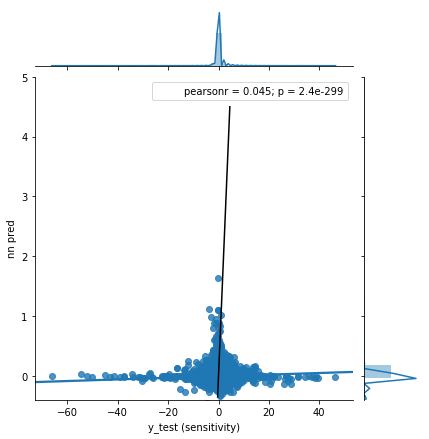

In [14]:
ax = sns.jointplot(x=y_test, y=nn_pred, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel="y_test (sensitivity)", ylabel="nn pred")
# fix y axis limits
ax.ax_marg_y.set_ylim(-0.4, 5)
# add bisector (in black)
plt.plot([-0.35, 4.5], [-0.35, 4.5], "k-")
plt.show()

In [15]:
print_ram_usage()

RAM usage: 147.72GB
